入力ファイル: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result/moca_age_stats.csv
出力ディレクトリ: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result
シミュレーション回数: 50
サンプル倍率: [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

シミュレーションを開始します...
ファイル 'G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result/moca_age_stats.csv' を読み込んでいます...
データ読み込み完了: 26行
カラム: ['Age', 'count', 'mean', 'std', 'min', 'max', 'MCI_count', 'MCI_percent']
既に計算された統計データを検出しました。
読み込み完了: 26の年齢群のデータ

年齢ごとのMOCAスコア統計（一部）:
   Age  count       mean       std  min  max  MCI_count  MCI_percent
0   57      1  29.000000  0.000000   29   29          0     0.000000
1   62      2  25.000000  1.414214   24   26          1    50.000000
2   64      1  26.000000  0.000000   26   26          0     0.000000
3   65     28  26.178571  1.925532   21   29         10    35.714286
4   66     44  25.409091  2.863712   18   30         21    47.727273

シミュレーション開始 (各倍率で50回)...
元データの総サンプル数: 1351
理論上の加重平均: 24.0836
母集団の推定標準偏差: 3.6910

1倍のサンプルサイズでシミュレーション中...
サンプル1倍 (1

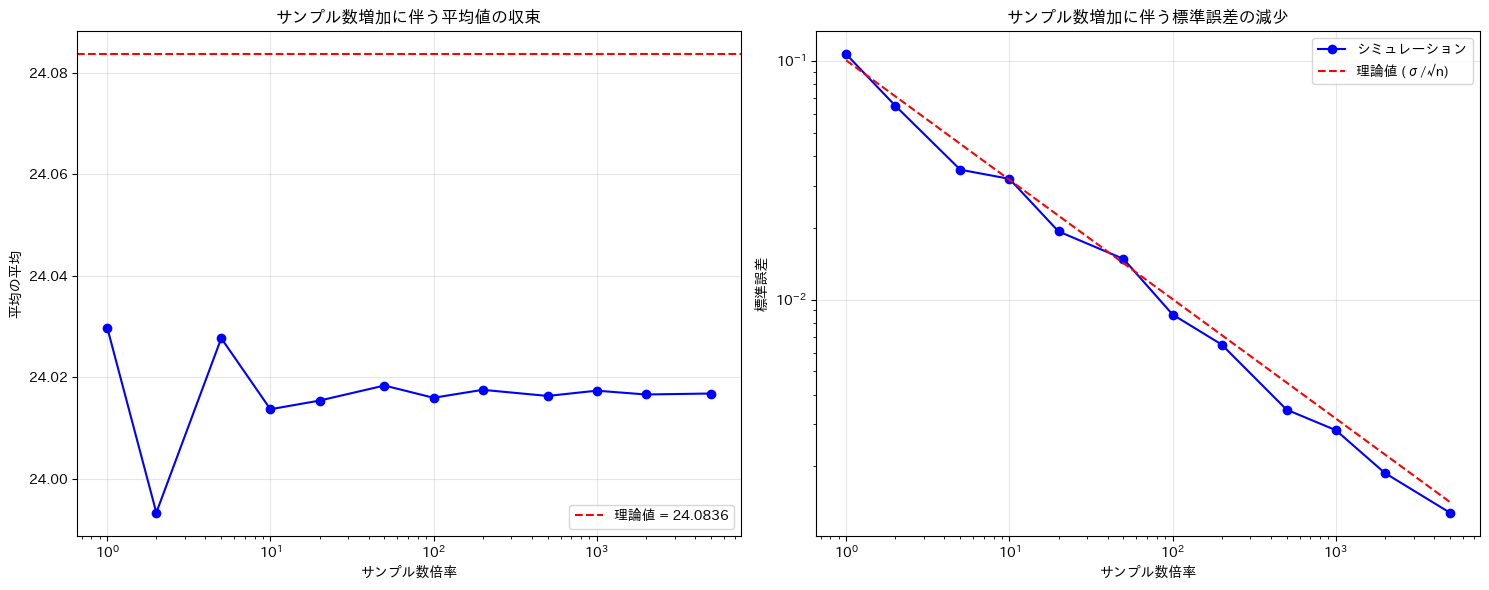


結論:
サンプル数を増やしていくと、MOCAスコアの平均の平均は 24.0836 に収束します


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import japanize_matplotlib
#------------------------------------------------------------
# ファイルパスの設定 - ここを変更してください
#------------------------------------------------------------
# データファイルのパス
path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result"
file_name = "moca_age_stats.csv"  # この部分を分析したいファイル名に変更
file_path = f"{path}/{file_name}"

# 結果の出力先
output_path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result"

# シミュレーション設定
simulation_runs = 50  # シミュレーションの実行回数（多いほど精度が上がるが時間がかかる）
multipliers = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000,2000,5000]  # サンプル数の倍率
#------------------------------------------------------------


# 1歳ごとのMOCAスコア統計データを読み込むための関数
def load_age_statistics(file_path):
    """
    1歳ごとのMOCAスコア統計を含むファイルを読み込む
    
    Parameters:
    file_path (str): MOCAスコア統計ファイルのパス
    
    Returns:
    pandas.DataFrame: 年齢、平均、標準偏差などを含むデータフレーム
    """
    try:
        print(f"ファイル '{file_path}' を読み込んでいます...")
        
        # ファイル拡張子を取得
        _, ext = os.path.splitext(file_path)
        
        if ext.lower() == '.csv':
            # CSVファイルとして読み込み
            try:
                df = pd.read_csv(file_path)
            except:
                # 区切り文字を変えて再試行
                df = pd.read_csv(file_path, sep=';')
        else:
            # タブ区切りファイルとして読み込み
            df = pd.read_csv(file_path, sep='\t')
        
        print(f"データ読み込み完了: {len(df)}行")
        print("カラム:", df.columns.tolist())
        
        # データ型の確認
        if 'MoCA' in df.columns and 'Age' in df.columns:
            print("生データを検出しました。年齢ごとの統計を計算します...")
            
            # 数値型に変換
            df['MoCA'] = pd.to_numeric(df['MoCA'], errors='coerce')
            df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
            
            # 無効な値を削除
            df = df.dropna()
            
            # データの一部を表示
            print("\nデータサンプル:")
            print(df.head())
            
            # 年齢ごとにグループ化して統計量を計算
            age_stats = df.groupby('Age').agg(
                count=('MoCA', 'size'),
                mean=('MoCA', 'mean'),
                std=('MoCA', 'std'),
                min=('MoCA', 'min'),
                max=('MoCA', 'max')
            ).reset_index()
            
            # 標準偏差がNaNの場合（サンプル数が1の場合）、0に設定
            age_stats['std'] = age_stats['std'].fillna(0)
            
            return age_stats
            
        elif len(df.columns) >= 3 and 'Age' in df.columns and 'mean' in df.columns and 'std' in df.columns:
            print("既に計算された統計データを検出しました。")
            # すでに統計情報が計算されているファイルの場合
            return df
        else:
            # カラム名が異なる場合、自動検出を試みる
            print("標準的なカラム名が見つかりません。自動検出を試みます...")
            
            # データの簡単な検査
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            
            if len(numeric_cols) >= 3 and len(df.columns) >= 3:
                # 数値型カラムから適切なものを推測
                possible_age_cols = [col for col in numeric_cols if df[col].min() >= 50 and df[col].max() <= 100]
                possible_moca_cols = [col for col in numeric_cols if df[col].min() >= 0 and df[col].max() <= 30]
                
                if possible_age_cols and possible_moca_cols:
                    age_col = possible_age_cols[0]
                    moca_col = possible_moca_cols[0]
                    
                    print(f"推測されたカラム: 年齢='{age_col}', MOCAスコア='{moca_col}'")
                    
                    # 必要なカラムだけ選択してリネーム
                    df_selected = df[[age_col, moca_col]].copy()
                    df_selected.columns = ['Age', 'MoCA']
                    
                    # 年齢ごとにグループ化して統計量を計算
                    age_stats = df_selected.groupby('Age').agg(
                        count=('MoCA', 'size'),
                        mean=('MoCA', 'mean'),
                        std=('MoCA', 'std'),
                        min=('MoCA', 'min'),
                        max=('MoCA', 'max')
                    ).reset_index()
                    
                    # 標準偏差がNaNの場合（サンプル数が1の場合）、0に設定
                    age_stats['std'] = age_stats['std'].fillna(0)
                    
                    return age_stats
            
            print(f"警告: 必要なデータ構造が見つかりません。")
            print("必要なカラム: 'Age'/'年齢' と 'MoCA'/'MOCA'/'モカ' など")
            return None
            
    except Exception as e:
        print(f"ファイル読み込みエラー: {e}")
        import traceback
        traceback.print_exc()
        return None

# 平均の収束シミュレーション関数
def simulate_mean_convergence(age_stats, multipliers=None, simulation_runs=100):
    """
    サンプル数を増やした場合の平均値の収束をシミュレーション
    
    Parameters:
    age_stats (DataFrame): 年齢ごとの平均と標準偏差を含むデータフレーム
    multipliers (list): サンプル数の増加倍率のリスト
    simulation_runs (int): 各倍率でのシミュレーション実行回数
    
    Returns:
    dict: シミュレーション結果を含む辞書
    """
    if multipliers is None:
        multipliers = [1, 2, 5, 10, 20, 50, 100, 500, 1000]
    
    # 理論上の加重平均を計算
    total_count = age_stats['count'].sum()
    weighted_mean = np.sum(age_stats['mean'] * age_stats['count']) / total_count
    
    print(f"元データの総サンプル数: {total_count}")
    print(f"理論上の加重平均: {weighted_mean:.4f}")
    
    # 母集団の分散の計算（年齢群間の分散 + 年齢群内の分散）
    # 各群の分散
    within_variance = np.sum(age_stats['std']**2 * age_stats['count']) / total_count
    # 群間の分散（平均の差による分散）
    between_variance = np.sum(((age_stats['mean'] - weighted_mean) ** 2) * age_stats['count']) / total_count
    # 全体の分散
    total_variance = within_variance + between_variance
    population_std = np.sqrt(total_variance)
    
    print(f"母集団の推定標準偏差: {population_std:.4f}")
    
    # シミュレーション結果保存用
    simulation_results = []
    
    # 各倍率でシミュレーション
    for multiplier in multipliers:
        print(f"\n{multiplier}倍のサンプルサイズでシミュレーション中...")
        
        run_means = []  # 各実行の平均値を保存
        
        for run in range(simulation_runs):
            # 各年齢群からサンプルを生成
            simulated_samples = []
            
            for _, row in age_stats.iterrows():
                age = row['Age']
                original_count = row['count']
                mean = row['mean']
                std_dev = row['std']
                
                # 新しいサンプル数
                new_count = int(original_count * multiplier)
                
                # 特殊ケース処理: 標準偏差が0の場合
                if std_dev == 0:
                    # 標準偏差が0の場合、全てのサンプルは平均値と等しい
                    samples = np.full(new_count, mean)
                else:
                    # 正規分布からサンプル生成
                    samples = np.random.normal(mean, std_dev, new_count)
                    
                    # MOCAスコアは0から30までの整数値
                    samples = np.clip(samples, 0, 30)
                    samples = np.round(samples)
                
                simulated_samples.extend(samples)
            
            # シミュレーションの平均値
            run_mean = np.mean(simulated_samples)
            run_means.append(run_mean)
        
        # 全実行の平均とばらつき
        mean_of_means = np.mean(run_means)
        std_of_means = np.std(run_means)
        
        # 理論上の標準誤差（標準偏差をサンプル数の平方根で割ったもの）
        expected_std_error = population_std / np.sqrt(total_count * multiplier)
        
        # 結果を保存
        simulation_results.append({
            'multiplier': multiplier,
            'sample_size': total_count * multiplier,
            'mean_of_means': mean_of_means,
            'std_of_means': std_of_means,
            'theoretical_mean': weighted_mean,
            'theoretical_std_error': expected_std_error
        })
        
        # 簡単な進捗報告
        print(f"サンプル{multiplier}倍 ({total_count * multiplier:,}人): "
              f"平均の平均 = {mean_of_means:.4f}, "
              f"平均の標準偏差 = {std_of_means:.4f}, "
              f"理論的誤差 = {expected_std_error:.4f}")
    
    # 結果のデータフレームを作成
    results_df = pd.DataFrame(simulation_results)
    
    return {
        'results': results_df,
        'weighted_mean': weighted_mean,
        'population_std': population_std,
        'original_sample_size': total_count
    }

# シミュレーション結果をグラフで可視化
def plot_simulation_results(simulation_data, output_file=None):
    """
    シミュレーション結果を可視化
    
    Parameters:
    simulation_data (dict): シミュレーション結果を含む辞書
    output_file (str): グラフの保存先ファイルパス（Noneの場合は保存しない）
    """
    results_df = simulation_data['results']
    weighted_mean = simulation_data['weighted_mean']
    
    # グラフ作成
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # サンプルサイズと平均値の関係
    ax1.axhline(y=weighted_mean, color='r', linestyle='--', 
                label=f'理論値 = {weighted_mean:.4f}')
    ax1.plot(results_df['multiplier'], results_df['mean_of_means'], 'o-b')
    ax1.set_xlabel('サンプル数倍率')
    ax1.set_ylabel('平均の平均')
    ax1.set_title('サンプル数増加に伴う平均値の収束')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # サンプルサイズと標準誤差の関係
    ax2.plot(results_df['multiplier'], results_df['std_of_means'], 'o-b', 
             label='シミュレーション')
    ax2.plot(results_df['multiplier'], results_df['theoretical_std_error'], 'r--', 
             label='理論値 (σ/√n)')
    ax2.set_xlabel('サンプル数倍率')
    ax2.set_ylabel('標準誤差')
    ax2.set_title('サンプル数増加に伴う標準誤差の減少')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    
    # ファイルに保存
    if output_file:
        plt.savefig(output_file)
        print(f"グラフを '{output_file}' に保存しました")
    
    # グラフを表示
    plt.show()
    
    return fig

# シミュレーション実行のメイン関数
def run_moca_convergence_simulation(input_file, output_dir=None, simulation_runs=50, multipliers=None):
    """
    MOCAスコアの平均収束シミュレーションを実行
    
    Parameters:
    input_file (str): 入力ファイルパス
    output_dir (str): 出力ディレクトリパス
    simulation_runs (int): シミュレーション実行回数
    multipliers (list): サンプル数の倍率リスト
    """
    # 統計データを読み込み
    age_stats = load_age_statistics(input_file)
    
    if age_stats is None:
        print("データの読み込みに失敗しました。")
        return
    
    print(f"読み込み完了: {len(age_stats)}の年齢群のデータ")
    
    # データの概要を表示
    print("\n年齢ごとのMOCAスコア統計（一部）:")
    print(age_stats.head())
    
    # シミュレーション実行
    print(f"\nシミュレーション開始 (各倍率で{simulation_runs}回)...")
    simulation_data = simulate_mean_convergence(age_stats, multipliers, simulation_runs)
    
    # 結果を表示
    print("\nシミュレーション結果:")
    print(simulation_data['results'])
    
    # 出力ディレクトリの設定
    if output_dir:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # 結果をCSVに保存
        results_csv = os.path.join(output_dir, 'moca_convergence_results.csv')
        simulation_data['results'].to_csv(results_csv, index=False)
        print(f"シミュレーション結果を '{results_csv}' に保存しました")
        
        # グラフを保存
        graph_file = os.path.join(output_dir, 'moca_convergence_graph.png')
        plot_simulation_results(simulation_data, graph_file)
    else:
        # グラフのみ表示
        plot_simulation_results(simulation_data)
    
    # 結論
    weighted_mean = simulation_data['weighted_mean']
    print("\n結論:")
    print(f"サンプル数を増やしていくと、MOCAスコアの平均の平均は {weighted_mean:.4f} に収束します")
    
    return simulation_data

# メイン処理 - ファイルを確認してシミュレーション実行
if __name__ == "__main__" or 'get_ipython' in globals():
    # ファイルの存在確認
    if not os.path.exists(file_path):
        print(f"エラー: ファイル '{file_path}' が見つかりません。")
        print(f"パスと名前を確認してください: {path} / {file_name}")
    else:
        # シミュレーション実行
        print(f"入力ファイル: {file_path}")
        print(f"出力ディレクトリ: {output_path}")
        print(f"シミュレーション回数: {simulation_runs}")
        print(f"サンプル倍率: {multipliers}")
        print("\nシミュレーションを開始します...")
        
        run_moca_convergence_simulation(file_path, output_path, simulation_runs, multipliers)